<a href="https://colab.research.google.com/github/ZahraFarahzadii/VAE-CVAE/blob/main/Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import libraries

Importing library and packages in Colaboratory

In [ ]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG
from keras import backend as K
from keras.layers import (Input, InputLayer, Dense, Lambda, Layer, Add, Multiply)
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.regularizers import l2


In the following block, we add MNIST dataset that is going to be trained on and do some prepossessing like reshaping and normalization

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
image_size = x_train.shape[1]
# Only get some data to train and test
train_len = 10000
test_len = 1000
x_train = np.reshape(x_train[:train_len], [-1, image_size, image_size, 1])
x_test = np.reshape(x_test[:test_len], [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_test = y_test[:test_len]

We get some dimentions belonging to our dataset and then define some constansts like number of epochs and batch size and laten dimention

In [ ]:
img_rows, img_cols, img_chns = x_train.shape[1:]
original_dim = img_rows * img_cols
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 400

#ENCODER

First, here's our encoder network, mapping inputs to our latent distribution parameters

First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma. Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor.

We create a sampling function to randomly sample from the distribution of the two-dimensional data generating in the encoder part. We assume the Gaussian distribution. To sampling the Gaussian distribution we generate normal random noise and reform it with mean and variance generated by the encoder(reparameterization trick).  

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

We Build an encoder model. We implement two fully connected layers with relu activation function to generate mean and variance of Gaussian latent variable z.

In [ ]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)


We can use these parameters to sample new similar points from the latent space:

In [ ]:
# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

We define encoder as follows:

In [ ]:
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_3[0][0]                   
____________________________________________________________________________________________

#DECODER

We Build a decoder model. We implement one fully connected, reshaping and convolutional layers with relu activation function to generate output image x.

In [ ]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)


We define decoder as follows:

In [ ]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

We build complet model of VAE

In [ ]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

define loss function to be optimized according to the article part 2.3

We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term.

In [ ]:
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

implement VAE model and set rmsprop as optimizer

In [ ]:
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 69076       encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Functional)            (None, 28, 28, 1)    65089       encoder[0][2]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   320         encoder_input[0][0]              
________________________________________________________________________________________________

#Model fitting

In [ ]:
history = vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None))
vae.save_weights('vae_cnn_mnist.h5')

Epoch 1/400
313/313 [==============================] - 19s 56ms/step - loss: 67.8519 - val_loss: 45.6122
Epoch 2/400
313/313 [==============================] - 17s 55ms/step - loss: 45.7086 - val_loss: 44.9626
Epoch 3/400
313/313 [==============================] - 17s 55ms/step - loss: 43.4316 - val_loss: 42.2422
Epoch 4/400
313/313 [==============================] - 17s 54ms/step - loss: 42.4689 - val_loss: 41.3832
Epoch 5/400
313/313 [==============================] - 17s 55ms/step - loss: 41.5985 - val_loss: 41.5592
Epoch 6/400
313/313 [==============================] - 17s 55ms/step - loss: 41.2673 - val_loss: 41.4162
Epoch 7/400
313/313 [==============================] - 17s 55ms/step - loss: 40.7907 - val_loss: 41.6654
Epoch 8/400
313/313 [==============================] - 17s 55ms/step - loss: 40.1946 - val_loss: 40.9135
Epoch 9/400
313/313 [==============================] - 17s 55ms/step - loss: 40.0828 - val_loss: 39.9306
Epoch 10/400
313/313 [==============================] -

#Model Evaluation

We will observe the loss function of VAE model over different epochs

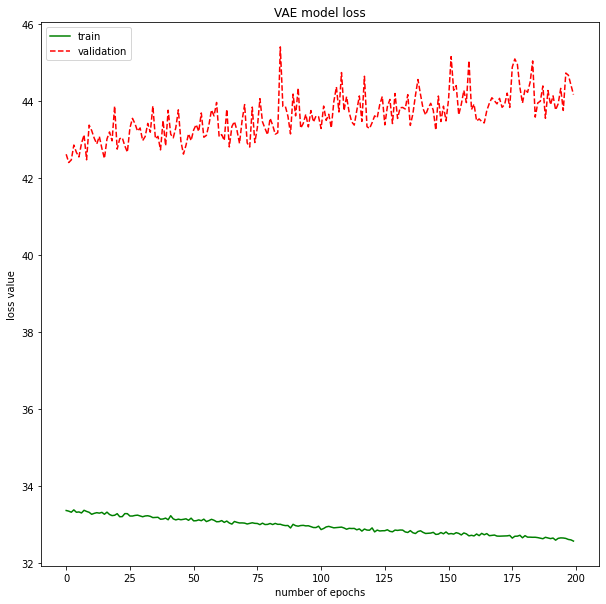

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'r--')
plt.title('VAE model loss')
plt.ylabel('loss value')
plt.xlabel('number of epochs')
plt.legend(['train','validation'], loc='upper left')
plt.show()

#2D Manifold space

We produce a normal distribution for the z1 and z2 as the vectors(to make a 2D space) which are going to feed the input. Then we can merge them and give them to the input of the learnt network. So the we can see the predicted output which will be similar to our dataset. So by generating some(here the dimention is n*n) normal random numbers and converting them to meaningless pictures, we could get to meaningful outputs of VAE.

In [ ]:
n = 20
quantile_min = 0.001
quantile_max = 0.999

z1 = norm.ppf(np.linspace(quantile_min, quantile_max, n))
z2 = norm.ppf(np.linspace(quantile_max, quantile_min, n))
z_grid = np.dstack(np.meshgrid(z1, z2))
x_pred_grid = decoder.predict(z_grid.reshape(n*n, latent_dim)) \
                     .reshape(n, n, img_rows, img_cols)

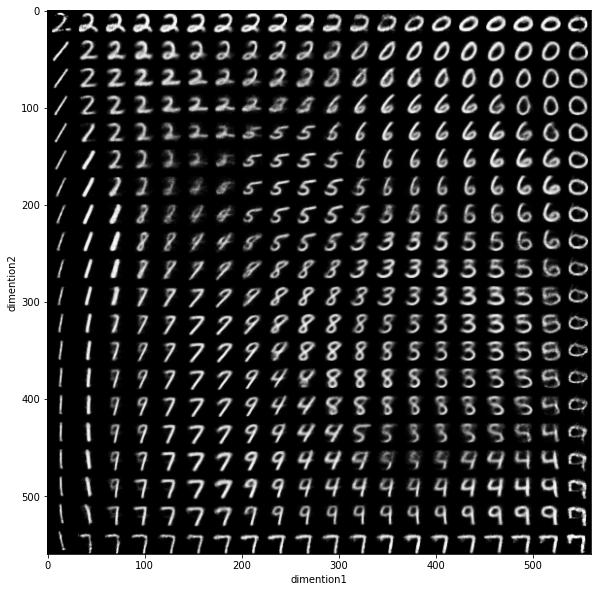

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
ax.set_xlabel('dimention1')
ax.set_ylabel('dimention2')
plt.show()

In the part below, we will see how to make clusters for our input.
We should consider that in this part, the input data is deterministic because of our purpose to cluster. All we need to do is to make a prediction to the test data according to our encoder part, because we wanna see if our encoder is able to do the act of partitioning or not.
Because our latent space is two-dimensional, there are a few cool visualizations that can be done at this point. One is to look at the neighborhoods of different classes on the latent 2D plane:

Each of these colored clusters is a type of digit. Close clusters are digits that are structurally similar

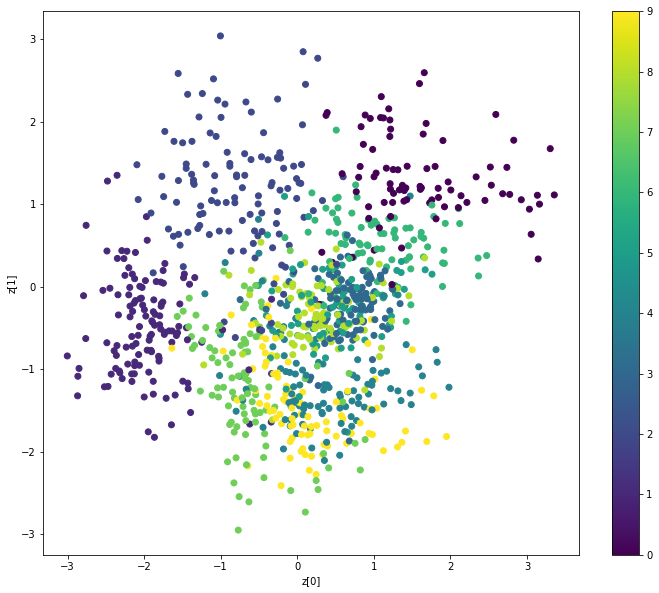

In [ ]:
z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

